In [1]:
import numpy as np
import pandas
import pm4py
from matplotlib import pyplot as plt
from sklearn.mixture import GaussianMixture
import scipy.stats as stats
import ot
import os
from tqdm import tqdm
import sys
sys.path.append('../../TaskExecutionTimeMining/')
from drbart_parser import *
from event_log_transformer import *


In [2]:
event_log = pandas.read_pickle('../transformed_event_logs/artificial_start_end_2.pickle')
event_log

,concept:name,lifecycle:transition_start,time:timestamp_start,org:resource,case:concept:name,lifecycle:transition_complete,time:timestamp_complete,duration,duration_seconds,seconds_in_day,1,Clark,Jane,Joe,Karsten,DIAGNOSIS,QUALITY_CONTROL,REPAIR
0,DIAGNOSIS,START,2020-01-01 03:57:40.044121+00:00,Jane,0,COMPLETE,2020-01-01 04:34:23.549454+00:00,0 days 00:36:43.505333,2203,14260,0,0,1,0,0,1,0,0
1,REPAIR,START,2020-01-01 04:34:23.549454+00:00,Joe,0,COMPLETE,2020-01-01 14:30:27.423999+00:00,0 days 09:56:03.874545,35763,16463,0,0,1,1,0,1,0,1
2,QUALITY_CONTROL,START,2020-01-01 14:30:27.423999+00:00,Joe,0,COMPLETE,2020-01-01 22:13:45.345445+00:00,0 days 07:43:17.921446,27797,52227,0,0,1,2,0,1,1,1
3,DIAGNOSIS,START,2020-01-01 08:16:35.844753+00:00,Jane,1,COMPLETE,2020-01-01 08:47:14.772217+00:00,0 days 00:30:38.927464,1838,29795,0,0,1,0,0,1,0,0
4,REPAIR,START,2020-01-01 08:47:14.772217+00:00,Karsten,1,COMPLETE,2020-01-01 13:27:22.316694+00:00,0 days 04:40:07.544477,16807,31634,0,0,1,0,1,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5399,QUALITY_CONTROL,START,2024-12-26 19:03:41.622915+00:00,Joe,1799,COMPLETE,2024-12-26 21:39:17.312456+00:00,0 days 02:35:35.689541,9335,68621,1,0,0,1,1,1,1,1
5400,DIAGNOSIS,START,2024-12-26 18:05:59.540931+00:00,Clark,1800,COMPLETE,2024-12-26 19:13:26.892809+00:00,0 days 01:07:27.351878,4047,65159,0,1,0,0,0,1,0,0
5401,REPAIR,START,2024-12-26 19:13:26.892809+00:00,Clark,1800,COMPLETE,2024-12-27 08:23:46.946760+00:00,0 days 13:10:20.053951,47420,69206,0,2,0,0,0,1,0,1
5402,QUALITY_CONTROL,START,2024-12-27 08:23:46.946760+00:00,Jane,1800,COMPLETE,2024-12-27 11:10:44.009123+00:00,0 days 02:46:57.062363,10017,30226,0,2,1,0,0,1,1,1


In [21]:
models_for_evaluation = [
    ('artificial/resource/', (['org:resource'], [])),
    ('artificial/concept-name/', (['concept:name'], [])),
    ('artificial/concept-name_resource/', (['concept:name', 'org:resource'], [])),
    ('artificial/concept-name_resource_seconds-in-day_activity-count/', (['concept:name', 'org:resource',
                                                                         'DIAGNOSIS', 'QUALITY_CONTROL', 'REPAIR'], ['seconds_in_day'])),
    ('artificial/concept-name_resource_seconds-in-day_resource-count/', (['concept:name', 'org:resource',
                                                                         '1', 'Clark', 'Jane', 'Joe', 'Karsten'], ['seconds_in_day'])),
]

## Qualitative evaluation

(20, 18)


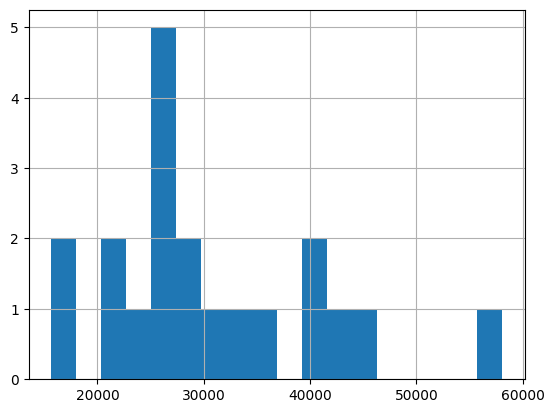

In [49]:
d = event_log[
        (event_log['concept:name'] == 'QUALITY_CONTROL') &
        (event_log['org:resource'] == 'Jane') &
        #(event_log['1'] == 0) &
        #(event_log['Clark'] == 0) &
        (event_log['Jane'] == 1) &
        (event_log['Joe'] == 2)# &
        #(event_log['Karsten'] == 0)
]
d['duration_seconds'].hist(bins=18)
print(d.shape)

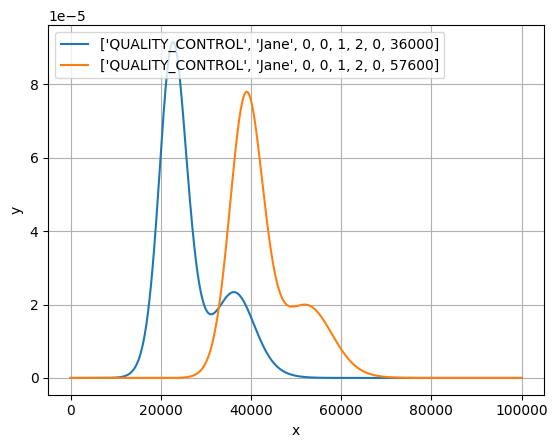

In [50]:
drbart = DRBART(parser_dir = '../../../models/'+models_for_evaluation[4][0])
x = np.linspace(0, 100000, 100000)
density = drbart.proba(x,
             [
                 ['QUALITY_CONTROL', 'Jane', 0, 0, 1, 2, 0],
                 ['QUALITY_CONTROL', 'Jane', 0, 0, 1, 2, 0]
             ],
             [
                 [10*3600],
                 [16*3600]
             ])

for j, i in density:
    plt.plot(x, i, label=str(j))
plt.legend(loc="upper left")
plt.grid(True)
plt.xlabel("x") 
plt.ylabel("y")
plt.show()


# Quantitative evaluation

## Activity based

In [ ]:
def min_max_time_percentile(x, categorical, continous, percentile):
    samples = drbart.sample([x[c] for c in categorical], [x[c] for c in continous], n = 100)[1]
    return np.percentile(samples, percentile), np.percentile(samples, 100-percentile)

for model in models_for_evaluation:
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    for i in range(0,50+1,10):
        event_log[['duration_sampled_seconds_min_'+str(i), 'duration_sampled_seconds_max_'+str(i)]] = \
            event_log.apply(lambda x : min_max_time_percentile(x, model[1][0], model[1][1], i), axis = 1, result_type='expand')
        event_log['real_duration_in_range_'+str(i)] = False
        event_log.loc[
            (event_log['duration_sampled_seconds_min_'+str(i)] <= event_log['duration_seconds']) & (event_log['duration_sampled_seconds_max_'+str(i)] >= event_log['duration_seconds']),
                'real_duration_in_range_'+str(i)
        ] = True
    x, y = [], []
    for i in range(0,50+1,10):
        x.append(100-i*2)
        y.append(event_log['real_duration_in_range_'+str(i)].mean()*100)
    print(y)
    plt.title(model[0])
    plt.scatter(x, y)
    plt.plot([0,100], [0,100], color='red', linestyle='--')
    plt.grid(True)
    plt.ylabel('Estimated Percentage')
    plt.show()
    

In [24]:
tqdm.pandas()

ev_event_log = event_log.sample(frac=1)

def drbart_proba(x, categorical, continous):
    p = drbart.proba([x['duration_seconds']], [[x[c] for c in categorical]], [[x[c] for c in continous]])[0][1]
    return np.log(p)

for model in models_for_evaluation[::-1]:
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    ev_event_log['model_proba']= \
            ev_event_log.progress_apply(lambda x : drbart_proba(x, model[1][0], model[1][1]), axis = 1)
    print(model[0], ev_event_log['model_proba'].sum())

 40%|████████████████████████████████████████████▎                                                                  | 2160/5404 [02:35<03:42, 14.61it/s]/home/michelkunkler/Documents/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [06:29<00:00, 13.87it/s]


artificial/concept-name_resource_seconds-in-day_resource-count/ [-50296.19433141]


 23%|█████████████████████████▋                                                                                     | 1252/5404 [02:10<06:45, 10.24it/s]/home/michelkunkler/Documents/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [09:19<00:00,  9.65it/s]


artificial/concept-name_resource_seconds-in-day_activity-count/ [-50891.2361843]


  0%|▎                                                                                                                | 14/5404 [00:02<16:49,  5.34it/s]/home/michelkunkler/Documents/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [16:36<00:00,  5.42it/s]


artificial/concept-name_resource/ [-51667.03762978]


  0%|▏                                                                                                                 | 7/5404 [00:01<23:25,  3.84it/s]/home/michelkunkler/Documents/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5404/5404 [25:29<00:00,  3.53it/s]


artificial/concept-name/ [-52404.33511227]


  0%|                                                                                                                          | 0/5404 [00:00<?, ?it/s]/home/michelkunkler/Documents/TaskExecutionTimeMining/src/notebooks/Artificial_Example/../../TaskExecutionTimeMining/drbart_parser.py:204: RuntimeWarning: divide by zero encountered in log
  lo = np.log(n)
  8%|█████████▍                                                                                                      | 453/5404 [03:46<41:12,  2.00it/s]


KeyboardInterrupt: 

## Process based

In [84]:
# assume sequential process model

num_scenarios = 1000

def drbart_sample(dbart, x, categorical, continous):
    s = drbart.sample([x[c] for c in categorical], [x[c] for c in continous])
    return s[1][0]

for model in models_for_evaluation:
    #model = models_for_evaluation[4]
    drbart = DRBART(parser_dir = '../../../models/'+model[0])
    categorical = model[1][0]
    continous = model[1][1]

    cases = event_log['case:concept:name'].unique()
    #cases = np.random.choice(event_log['case:concept:name'].unique(), size=100, replace=False)
    res = []
    for case in tqdm(cases):
        senario_results = []
        scenario_results = []
        for i in range(num_scenarios):
            case_event_log = event_log[event_log['case:concept:name'] == case].sort_values('time:timestamp_start').copy()
            current_time = case_event_log['time:timestamp_start'].min()
            runtime = 0
            for index, row in case_event_log.iterrows():
                row['time:timestamp_start'] = current_time
                dt = current_time.to_pydatetime()
                row['seconds_in_day'] = dt.hour * 3600 + dt.minute * 60 + dt.second
                s = drbart_sample(drbart, row, categorical, continous)
                current_time += datetime.timedelta(seconds=s)
                runtime += s
                #print(current_time, s)
            #print(case_event_log['time:timestamp_complete'].max(), case_event_log['duration_seconds'].sum())
            #print('---')
            scenario_results.append(runtime)
        prob_90_duration = np.percentile(scenario_results, 90)
        real_duration = case_event_log['duration_seconds'].sum()
        res.append(prob_90_duration > real_duration)

    print(model[0], np.mean(res))
    #np.mean(res)

  1%|█                                                                                                              | 18/1802 [00:58<1:36:28,  3.24s/it]


KeyboardInterrupt: 